# Fine-Tune LSTM

## Load libraries

In [1]:
import os # store and load weight
import pandas as pd # load data
import nltk # text processing
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer # text processing
from nltk.corpus import stopwords #text processing
import numpy as np # one-hot vector
import matplotlib.pyplot as plt # model analysis
from itertools import chain # feature construction
from collections import Counter # build feats-dict
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# import keras
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

# Get index vector
def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [5]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):

    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

## Load data

In [6]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess data

In [7]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [8]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


In [9]:
# extract features
min_freq = 3

train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_feats = [filter_stopwords(tokens) for tokens in valid_stemmed]
test_feats = [filter_stopwords(tokens) for tokens in test_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 2465


In [10]:
max_len = 75 # from EDA

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels, num_classes=num_labels)
valid_label_matrix = keras.utils.to_categorical(valid_labels, num_classes=num_labels)
test_label_matrix = tf.keras.utils.to_categorical(test_labels, num_classes=num_labels)

## Fine-Tune Model  
    
embedding_size  
hidden_size  
num_rnn_layers  
num_mlp_layers  
activation  
dropout_rate  
batch_norm  
l2_reg  
optimizer  
learning_rate  

In [11]:
# set seed
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# indicator for saving models' weights
count = 0

# lstm
rnn_type="lstm"
bidirectional=False

# initial settings
epoch = 50
batch_size = 100

embedding_size=100 #256
hidden_size=100 #256
num_rnn_layers=1
num_mlp_layers=2
activation='tanh'
dropout_rate=0.5
batch_norm=True
l2_reg=0.005
optimizer="Adam"
learning_rate=0.1

### Optimizer

In [13]:
optimizer_list = ['SGD', 'RMSprop', 'Adam']
best_optimizer = ''
best_acc = 0
best_f1 = 0

for optimizer in optimizer_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=1,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'optimizer: {optimizer}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_optimizer = optimizer
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'optimizer: {best_optimizer}, accuracy: {best_acc}, macro_f1: {best_f1}')

Epoch 1/50
37/37 [==============================] - 9s 31ms/step - loss: 3.3551 - accuracy: 0.1150 - precision: 0.0714 - recall: 5.4870e-04 - val_loss: 3.1295 - val_accuracy: 0.1086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 0s 11ms/step - loss: 3.1731 - accuracy: 0.1155 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0730 - val_accuracy: 0.1111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
37/37 [==============================] - 0s 12ms/step - loss: 3.0967 - accuracy: 0.1095 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0133 - val_accuracy: 0.1136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
37/37 [==============================] - 0s 10ms/step - loss: 3.0210 - accuracy: 0.1106 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9590 - val_accuracy: 0.1086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
37/37 [==============================

In [18]:
optimizer = best_optimizer

### embedding_size

In [20]:
embedding_size_list = [50, 75, 100, 128, 256]
best_embedding_size = 0
best_acc = 0
best_f1 = 0

for embedding_size in embedding_size_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'embedding_size: {embedding_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_embedding_size = embedding_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'embedding_size: {best_embedding_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 10
embedding_size: 50
accuracy: 0.5531
macro_f1: 0.5503
----------------------------------------------------------------------------
count: 11
embedding_size: 75
accuracy: 0.2741
macro_f1: 0.1431
----------------------------------------------------------------------------
count: 12
embedding_size: 100
accuracy: 0.2494
macro_f1: 0.1499
----------------------------------------------------------------------------
count: 13
embedding_size: 128
accuracy: 0.2148
macro_f1: 0.1028
----------------------------------------------------------------------------
count: 14
embedding_size: 256
accuracy: 0.3111
macro_f1: 0.1951
----------------------------------------------------------------------------
Best model:
embedding_size: 50, accuracy: 0.5530864197530864, macro_f1: 0.5503406992243404


In [16]:
embedding_size = best_embedding_size

### hidden_size

In [21]:
hidden_size_list = [50, 75, 100, 128, 256]
best_hidden_size = 0
best_acc = 0
best_f1 = 0

for hidden_size in hidden_size_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'hidden_size: {hidden_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_hidden_size = hidden_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'hidden_size: {best_hidden_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 15
hidden_size: 50
accuracy: 0.3654
macro_f1: 0.3234
----------------------------------------------------------------------------
count: 16
hidden_size: 75
accuracy: 0.2815
macro_f1: 0.1666
----------------------------------------------------------------------------
count: 17
hidden_size: 100
accuracy: 0.4815
macro_f1: 0.4209
----------------------------------------------------------------------------
count: 18
hidden_size: 128
accuracy: 0.2395
macro_f1: 0.1217
----------------------------------------------------------------------------
count: 19
hidden_size: 256
accuracy: 0.4346
macro_f1: 0.3739
----------------------------------------------------------------------------
Best model:
hidden_size: 100, accuracy: 0.48148148148148145, macro_f1: 0.4209012345517303


In [22]:
hidden_size = best_hidden_size

### num_rnn_layers

In [23]:
num_rnn_layers_list = [1, 2, 3, 4, 5]
best_num_rnn_layers = 0
best_acc = 0
best_f1 = 0

for num_rnn_layers in num_rnn_layers_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'num_rnn_layers: {num_rnn_layers}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_num_rnn_layers = num_rnn_layers
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'num_rnn_layers: {best_num_rnn_layers}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 20
num_rnn_layers: 1
accuracy: 0.2790
macro_f1: 0.1676
----------------------------------------------------------------------------
count: 21
num_rnn_layers: 2
accuracy: 0.2123
macro_f1: 0.0885
----------------------------------------------------------------------------
count: 22
num_rnn_layers: 3
accuracy: 0.7136
macro_f1: 0.7153
----------------------------------------------------------------------------
count: 23
num_rnn_layers: 4
accuracy: 0.7259
macro_f1: 0.7240
----------------------------------------------------------------------------
count: 24
num_rnn_layers: 5
accuracy: 0.4840
macro_f1: 0.4742
----------------------------------------------------------------------------
Best model:
num_rnn_layers: 4, accuracy: 0.725925925925926, macro_f1: 0.7240019332033676


In [24]:
num_rnn_layers = best_num_rnn_layers

### num_mlp_layers

In [25]:
num_mlp_layers_list = [1, 2, 3, 4, 5]
best_num_mlp_layers = 0
best_acc = 0
best_f1 = 0

for num_mlp_layers in num_mlp_layers_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'num_mlp_layers: {num_mlp_layers}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_num_mlp_layers = num_mlp_layers
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'num_mlp_layers: {best_num_mlp_layers}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 25
num_mlp_layers: 1
accuracy: 0.6938
macro_f1: 0.6933
----------------------------------------------------------------------------
count: 26
num_mlp_layers: 2
accuracy: 0.7481
macro_f1: 0.7481
----------------------------------------------------------------------------
count: 27
num_mlp_layers: 3
accuracy: 0.1160
macro_f1: 0.0318
----------------------------------------------------------------------------
count: 28
num_mlp_layers: 4
accuracy: 0.5580
macro_f1: 0.5304
----------------------------------------------------------------------------
count: 29
num_mlp_layers: 5
accuracy: 0.1111
macro_f1: 0.0223
----------------------------------------------------------------------------
Best model:
num_mlp_layers: 2, accuracy: 0.7481481481481481, macro_f1: 0.74813020078548


In [26]:
num_mlp_layers = best_num_mlp_layers

### dropout_rate

In [27]:
dropout_rate_list = [0.1, 0.3, 0.5, 0.6, 0.7]
best_dropout_rate = 0
best_acc = 0
best_f1 = 0

for dropout_rate in dropout_rate_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'dropout_rate: {dropout_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_dropout_rate = dropout_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'dropout_rate: {best_dropout_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 30
dropout_rate: 0.1
accuracy: 0.7457
macro_f1: 0.7462
----------------------------------------------------------------------------
count: 31
dropout_rate: 0.3
accuracy: 0.7432
macro_f1: 0.7435
----------------------------------------------------------------------------
count: 32
dropout_rate: 0.5
accuracy: 0.7432
macro_f1: 0.7447
----------------------------------------------------------------------------
count: 33
dropout_rate: 0.6
accuracy: 0.6914
macro_f1: 0.6883
----------------------------------------------------------------------------
count: 34
dropout_rate: 0.7
accuracy: 0.6667
macro_f1: 0.6665
----------------------------------------------------------------------------
Best model:
dropout_rate: 0.1, accuracy: 0.745679012345679, macro_f1: 0.7462466268603757


In [28]:
dropout_rate = best_dropout_rate

### batch_norm

In [29]:
batch_norm_list = [True, False]
best_batch_norm = False
best_acc = 0
best_f1 = 0

for batch_norm in batch_norm_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'batch_norm: {batch_norm}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_batch_norm = batch_norm
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'batch_norm: {best_batch_norm}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 35
batch_norm: True
accuracy: 0.7481
macro_f1: 0.7514
----------------------------------------------------------------------------
count: 36
batch_norm: False
accuracy: 0.5160
macro_f1: 0.4911
----------------------------------------------------------------------------
Best model:
batch_norm: True, accuracy: 0.7481481481481481, macro_f1: 0.7513985752395633


In [30]:
batch_norm = best_batch_norm

### l2_reg

In [31]:
l2_reg_list = [0.001, 0.005, 0.01, 0.1]
best_l2_reg = 0
best_acc = 0
best_f1 = 0

for l2_reg in l2_reg_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'l2_reg: {l2_reg}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_l2_reg = l2_reg
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'l2_reg: {best_l2_reg}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 37
l2_reg: 0.001
accuracy: 0.7506
macro_f1: 0.7466
----------------------------------------------------------------------------
count: 38
l2_reg: 0.005
accuracy: 0.7506
macro_f1: 0.7519
----------------------------------------------------------------------------
count: 39
l2_reg: 0.01
accuracy: 0.7383
macro_f1: 0.7367
----------------------------------------------------------------------------
count: 40
l2_reg: 0.1
accuracy: 0.7383
macro_f1: 0.7367
----------------------------------------------------------------------------
Best model:
l2_reg: 0.005, accuracy: 0.7506172839506173, macro_f1: 0.7518850451938072


In [32]:
l2_reg = best_l2_reg

### learning_rate

In [33]:
learning_rate_list = [0.0001, 0.001, 0.01, 0.1]
best_learning_rate = 0
best_acc = 0
best_f1 = 0

for learning_rate in learning_rate_list:

    count += 1

    model = build_RNN(input_length=max_len, 
                          vocab_size=len(feats_dict), 
                          embedding_size=embedding_size,
                          hidden_size=hidden_size, 
                          output_size=9,
                          num_rnn_layers=num_rnn_layers, 
                          num_mlp_layers=num_mlp_layers,
                          rnn_type=rnn_type,
                          bidirectional=bidirectional,
                          activation=activation,
                          dropout_rate=dropout_rate,
                          batch_norm=batch_norm,
                          l2_reg=l2_reg,
                          optimizer=optimizer,
                          learning_rate=learning_rate,
                        )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_RNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_RNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'learning_rate: {learning_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_learning_rate = learning_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'learning_rate: {best_learning_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 41
learning_rate: 0.0001
accuracy: 0.7580
macro_f1: 0.7582
----------------------------------------------------------------------------
count: 42
learning_rate: 0.001
accuracy: 0.7580
macro_f1: 0.7622
----------------------------------------------------------------------------
count: 43
learning_rate: 0.01
accuracy: 0.7679
macro_f1: 0.7686
----------------------------------------------------------------------------
count: 44
learning_rate: 0.1
accuracy: 0.7457
macro_f1: 0.7464
----------------------------------------------------------------------------
Best model:
learning_rate: 0.01, accuracy: 0.7679012345679013, macro_f1: 0.7685730272578604


In [34]:
learning_rate = best_learning_rate

## Final LSTM Model

In [45]:
model = build_RNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size,
                      hidden_size=hidden_size, 
                      output_size=9,
                      num_rnn_layers=num_rnn_layers, 
                      num_mlp_layers=num_mlp_layers,
                      rnn_type=rnn_type,
                      bidirectional=bidirectional,
                      activation=activation,
                      dropout_rate=dropout_rate,
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                    )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", f"weights_RNN_final.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(valid_feats_matrix, valid_label_matrix),
                    epochs=epoch, batch_size=batch_size, verbose=1,
                    callbacks=[checkpointer])

model = keras.models.load_model(os.path.join("models", f"weights_RNN_final.hdf5"))

print(f'count: {count}')
print(f'learning_rate: {learning_rate}')

# evaluation
# generate prediction and format
y_pred = model.predict(valid_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred, average='macro')
print(f'accuracy: {acc:.4f}')
print(f'macro_f1: {f1:.4f}')

Epoch 1/50
37/37 [==============================] - 9s 75ms/step - loss: 3.1815 - accuracy: 0.1139 - precision_48: 0.0385 - recall_48: 2.7435e-04 - val_loss: 2.9903 - val_accuracy: 0.1160 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 1s 28ms/step - loss: 2.8342 - accuracy: 0.1427 - precision_48: 0.3626 - recall_48: 0.0091 - val_loss: 2.7740 - val_accuracy: 0.1160 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00
Epoch 3/50
37/37 [==============================] - 1s 29ms/step - loss: 2.3468 - accuracy: 0.2532 - precision_48: 0.5635 - recall_48: 0.0390 - val_loss: 2.4353 - val_accuracy: 0.1951 - val_precision_48: 1.0000 - val_recall_48: 0.0198
Epoch 4/50
37/37 [==============================] - 1s 30ms/step - loss: 2.0781 - accuracy: 0.2988 - precision_48: 0.6102 - recall_48: 0.0623 - val_loss: 2.2604 - val_accuracy: 0.2938 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00
Epoch 5/50
37/37 [==============

## Final Model Test Prediction

In [46]:
# generate prediction and format
y_pred = model.predict(test_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='macro')
print(f'test accuracy: {acc:.4f}')
print(f'test macro_f1: {f1:.4f}')
print(classification_report(test_labels, y_pred,target_names=labels))

test accuracy: 0.7644
test macro_f1: 0.7672
              precision    recall  f1-score   support

          CC       0.96      0.88      0.92        50
          NC       0.79      0.82      0.80        50
          PW       0.79      0.84      0.82        50
          HC       0.51      0.56      0.53        50
          PL       0.78      0.72      0.75        50
          CR       0.64      0.76      0.70        50
          CG       0.90      0.74      0.81        50
          BE       0.79      0.82      0.80        50
           N       0.80      0.74      0.77        50

    accuracy                           0.76       450
   macro avg       0.77      0.76      0.77       450
weighted avg       0.77      0.76      0.77       450



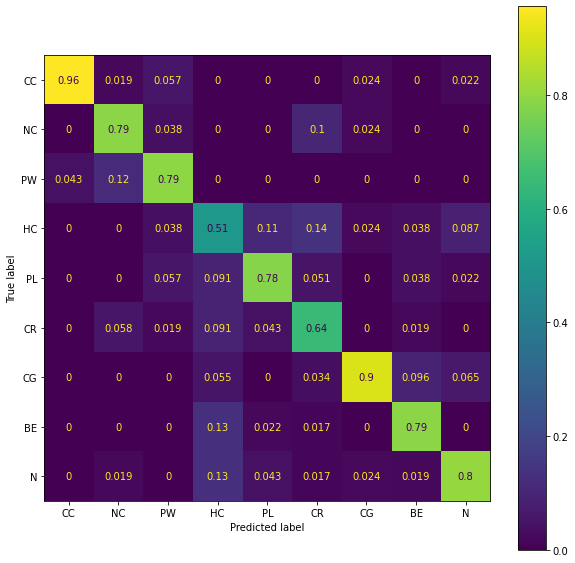

In [47]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)